This can be run [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework_3/blob/main/HW3.1-Classifiers.ipynb)

## MNIST Classifiers (Convolutional Neural Networks and Fully Connected Networks)

<b>Optional</b>: Installing Wandb to see cool analysis of you code. You can go through the documentation here. We will do it for this assignment to get a taste of the GPU and CPU utilizations. If this is creating problems to your code, please comment out all the wandb lines from the notebook

In [1]:
# Uncomment the below line to install wandb (optinal)
!pip install wandb
# Uncomment the below line to install torchinfo (https://github.com/TylerYep/torchinfo) [Mandatory]
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 28.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=cd6e82b6fc6bd02d85b7d23767edf6020bdc7c83fe4bc4183a53ee767d5a5931
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
%%bash

wget -N https://cs7150.baulab.info/2022-Fall/data/mnist-classify.pth

--2023-10-15 03:18:53--  https://cs7150.baulab.info/2022-Fall/data/mnist-classify.pth
Resolving cs7150.baulab.info (cs7150.baulab.info)... 35.232.255.106
Connecting to cs7150.baulab.info (cs7150.baulab.info)|35.232.255.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1078198 (1.0M)
Saving to: ‘mnist-classify.pth’

     0K .......... .......... .......... .......... ..........  4%  121K 8s
    50K .......... .......... .......... .......... ..........  9%  248K 6s
   100K .......... .......... .......... .......... .......... 14% 5.31M 4s
   150K .......... .......... .......... .......... .......... 18%  671K 3s
   200K .......... .......... .......... .......... .......... 23%  395K 3s
   250K .......... .......... .......... .......... .......... 28% 5.80M 2s
   300K .......... .......... .......... .......... .......... 33% 1.82M 2s
   350K .......... .......... .......... .......... .......... 37% 1.21M 1s
   400K .......... .......... .......... ......

In [3]:
# Importing libraries
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split,Subset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np
import datetime

from typing import List
from collections import OrderedDict
import math

In [4]:
# Create an account at https://wandb.ai/site and paste the api key here (optional)
import wandb
wandb.init(project="hw3.1-ConvNets")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Some helper functions to view network parameters

In [5]:
def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print('Model Summary\n')
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print('{}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))
    print(f'\nTotal Trainable Parameters: {total_parameters}!')

In [6]:
def view_network_shapes(model, input_shape):
    print(summary(conv_net, input_size=input_shape))

### Fully Connected Network for Image Classification
Let's build a simple fully connected network!

In [7]:
def simple_fc_net():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model

In [8]:
fc_net = simple_fc_net()

In [9]:
view_network_parameters(fc_net)

Model Summary

1.weight: 4917248 elements
1.bias: 6272 elements
3.weight: 19668992 elements
3.bias: 3136 elements
5.weight: 4917248 elements
5.bias: 1568 elements
7.weight: 451584 elements
7.bias: 288 elements
9.weight: 18432 elements
9.bias: 64 elements
11.weight: 640 elements
11.bias: 10 elements

Total Trainable Parameters: 29985482!


In [10]:
from torchinfo import summary
summary(fc_net, input_size=(1, 1, 28,28))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 6272]                 4,923,520
├─ReLU: 1-3                              [1, 6272]                 --
├─Linear: 1-4                            [1, 3136]                 19,672,128
├─ReLU: 1-5                              [1, 3136]                 --
├─Linear: 1-6                            [1, 1568]                 4,918,816
├─ReLU: 1-7                              [1, 1568]                 --
├─Linear: 1-8                            [1, 288]                  451,872
├─ReLU: 1-9                              [1, 288]                  --
├─Linear: 1-10                           [1, 64]                   18,496
├─ReLU: 1-11                             [1, 64]                   --
├─Linear: 1-12                           [1, 10]      

<b>Exercise</b>: Now try to add different layers and see how the network parameters vary. Does adding layers reduce the parameters? Does the number of hidden neurons in the layers affect the total trainable parameters?

**Answer:** No, adding layers to a network architecture typically increases the number of parameters in a neural network.

**Effect on trainable parameters:**

**Case 1: Increasing the layers**

*  A new linear layer of size (64, 128) was added to the existing architecure.

* This results in increase in the number of trainable parameters.

**Case 2: Decreasing the layers**

* Similarly when we remove a layer from the architecture, it results in decrease in the number of trainable parameters.

In [11]:
# Case 1: Increasing the layers

def fc_net_extra_layer():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28, 8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28, 16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14, 32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7, 288),
        nn.ReLU(),
        nn.Linear(288, 64),
        nn.ReLU(),
        nn.Linear(64, 128),  # New layer
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.LogSoftmax()
    )
    return model

view_network_parameters(fc_net_extra_layer())


Model Summary

1.weight: 4917248 elements
1.bias: 6272 elements
3.weight: 19668992 elements
3.bias: 3136 elements
5.weight: 4917248 elements
5.bias: 1568 elements
7.weight: 451584 elements
7.bias: 288 elements
9.weight: 18432 elements
9.bias: 64 elements
11.weight: 8192 elements
11.bias: 128 elements
13.weight: 1280 elements
13.bias: 10 elements

Total Trainable Parameters: 29994442!


In [12]:
# Case 2: Decreasing the layers

def fc_net_decreased_layer():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28, 8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28, 32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7, 288),
        nn.ReLU(),
        nn.Linear(288, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.LogSoftmax()
    )
    return model

view_network_parameters(fc_net_decreased_layer())


Model Summary

1.weight: 4917248 elements
1.bias: 6272 elements
3.weight: 9834496 elements
3.bias: 1568 elements
5.weight: 451584 elements
5.bias: 288 elements
7.weight: 18432 elements
7.bias: 64 elements
9.weight: 640 elements
9.bias: 10 elements

Total Trainable Parameters: 15230602!


### Convolutional Neural Network for Image Classification
Let's build a simple CNN to classify our images.
<b> Exercise 3.1.1:</b> In the function below please add the conv/Relu/Maxpool layers to match the shape of FC-Net. Suppose at the some layer the FC-Net has `28*28*16` dimension, we want your conv_net to have `16 X 28 X 28` shape at the same numbered layer. <br>
<b>Extra-credit:</b> Try not to use MaxPool2d !

In [13]:
def simple_conv_net():
    model = nn.Sequential(
        nn.Conv2d(1,16,kernel_size=3,padding=1),
        nn.ReLU(),
        #nn.MaxPool2d(2,2),
        # TO-DO: Add layers below
        #'''Add your code here to match the output shape of the FC-Net'''

        nn.Conv2d(16,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,padding=1),
        nn.ReLU(),

        # TO-DO, what will your shape be after you flatten? Fill it in place of None
        nn.Flatten(),
        nn.Linear(64*28*28, 64),
        # Do not change the code below
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.LogSoftmax())
    return model

In [14]:
conv_net = simple_conv_net()

In [15]:
view_network_parameters(conv_net)

Model Summary

0.weight: 144 elements
0.bias: 16 elements
2.weight: 4608 elements
2.bias: 32 elements
4.weight: 18432 elements
4.bias: 64 elements
7.weight: 3211264 elements
7.bias: 64 elements
9.weight: 640 elements
9.bias: 10 elements

Total Trainable Parameters: 3235274!


In [16]:
view_network_shapes(conv_net, input_shape=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─ReLU: 1-2                              [1, 16, 28, 28]           --
├─Conv2d: 1-3                            [1, 32, 28, 28]           4,640
├─ReLU: 1-4                              [1, 32, 28, 28]           --
├─Conv2d: 1-5                            [1, 64, 28, 28]           18,496
├─ReLU: 1-6                              [1, 64, 28, 28]           --
├─Flatten: 1-7                           [1, 50176]                --
├─Linear: 1-8                            [1, 64]                   3,211,328
├─ReLU: 1-9                              [1, 64]                   --
├─Linear: 1-10                           [1, 10]                   650
├─LogSoftmax: 1-11                       [1, 10]                   --
Total params: 3,235,274
Trainable params: 3,235,274
Non-trainable par

<b>Exercise 3.1.2</b>: Why is the final layer a log softmax? What is a softmax function? Can we use ReLU instead of softmax? If yes, what would you do different? If not, tell us why. If you think there is a different answer, feel free to use this space to chart it down

 **Answer:**

 The final layer in a neural network for a classification task is a log softmax function since it generates the probability of an image/object belonging to each class.

 **Softmax function:** The softmax function is used to convert the network's output scores into probability distributions for multiple classes. It takes as input a vector of output scores and transforms them into a probability distribution where the sum of the probabilities for all classes equals 1.

 No, using a ReLU function is not advised for the last layer. Since ReLU function is used as an activation function within hidden layers of a neural network to introduce non-linearity. It doesn't provide a probabilities required for classificatiion task like softmax.



<b>Exercise 3.1.3</b>: What is the ratio of number of parameters of Conv-net to number of parameters of FC-Net <br>
$\frac{p_{conv-net}}{p_{fc-net}} = \frac{3,235,274}{29,985,482} = 0.10$ <br>

Do you see the difference ?!

**Answer:** Yes, the number of parameter reduced drastically with a convolution nueral network architecture.

<b>Exercise 3.1.4</b>: Now try to add different layers and see how the network parameters vary. Does adding layers reduce the parameters? Does the number of hidden neurons in the layers affect the total trainable parameters? Use the `build_custom_fc_net` function given below. You do not have to understand the working of it.

**Answer:**
* No, adding layers to a network architecture typically increases the number of parameters in a neural network.

* Yes, the number of hidden neurons in the layers directly affects the total trainable parameters. Increasing the number of neurons in a layer increases the number of parameters (weights and biases) in that layer, leading to a higher total number of trainable parameters in the neural network.

I have used the `build_custom_fc_net` function to build three different network architectures.

* Network 1 [`128,64,32`]: In the first network, we have three hidden layers with 32, 64 and 128 neurons respectively. The total number of trainable parameters are `111146`.

* Network 2 [`64,32`]: In the second network, we have two hidden layers with 32 and 64 neurons respectively. The total number of trainable parameters are `52650`.

* Network 3 [`256,128,64,32`]: In the second network, we have four hidden layers with 32, 64, 128, 256 neurons respectively. The total number of trainable parameters are `244522`.

This proves that the total number of trainable parameters increase as we increase the number of layers and number of neurons in each hidden layer.

In [17]:
def build_custom_fc_net(inp_dim: int, out_dim: int, hidden_fc_dim: List[int]):
    '''
    Inputs :

    inp_dim: Shape of the input dimensions (in MNIST case 28*28)
    out_dim: Desired classification classes (in MNIST case 10)
    hidden_fc_dim: List of the intermediate dimension shapes (list of integers). Try different values and see the shapes'

    Return: nn.Sequential (final custom model)
    '''
    assert type(hidden_fc_dim) == list, "Please define hidden_fc_dim as list of integers"
    layers = []
    layers.append((f'flatten', nn.Flatten()))
    # If no hidden layer is required
    if len(hidden_fc_dim) == 0:
        layers.append((f'linear',nn.Linear(math.prod(inp_dim),out_dim)))
        layers.append((f'activation',nn.LogSoftmax()))
    else:
        # Loop over hidden dimensions and add layers
        for idx, dim in enumerate(hidden_fc_dim):
            if idx == 0:
                layers.append((f'linear_{idx+1}',nn.Linear(math.prod(inp_dim),dim)))
                layers.append((f'activation_{idx+1}',nn.ReLU()))
            else:
                layers.append((f'linear_{idx+1}',nn.Linear(hidden_fc_dim[idx-1],dim)))
                layers.append((f'activation_{idx+1}',nn.ReLU()))
        layers.append((f'linear_{idx+2}',nn.Linear(dim,out_dim)))
        layers.append((f'activation_{idx+2}',nn.LogSoftmax()))

    model =  nn.Sequential(OrderedDict(layers))
    return model

# TO-DO build different networks (atleast 3) and see the parameters
#(You don't have to understand the function above. It is a generic way to build a FC-Net)


fc_net_custom1 = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[128,64,32])
view_network_parameters(fc_net_custom1)

fc_net_custom2 = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[64,32])
view_network_parameters(fc_net_custom2)

fc_net_custom3 = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[256,128,64,32])
view_network_parameters(fc_net_custom3)

Model Summary

linear_1.weight: 100352 elements
linear_1.bias: 128 elements
linear_2.weight: 8192 elements
linear_2.bias: 64 elements
linear_3.weight: 2048 elements
linear_3.bias: 32 elements
linear_4.weight: 320 elements
linear_4.bias: 10 elements

Total Trainable Parameters: 111146!
Model Summary

linear_1.weight: 50176 elements
linear_1.bias: 64 elements
linear_2.weight: 2048 elements
linear_2.bias: 32 elements
linear_3.weight: 320 elements
linear_3.bias: 10 elements

Total Trainable Parameters: 52650!
Model Summary

linear_1.weight: 200704 elements
linear_1.bias: 256 elements
linear_2.weight: 32768 elements
linear_2.bias: 128 elements
linear_3.weight: 8192 elements
linear_3.bias: 64 elements
linear_4.weight: 2048 elements
linear_4.bias: 32 elements
linear_5.weight: 320 elements
linear_5.bias: 10 elements

Total Trainable Parameters: 244522!


## Let's train the models to see their performace

In [18]:
# downloading mnist into folder
data_dir = 'data' # make sure that this folder is created in your working dir
# transform the PIL images to tensor using torchvision.transform.toTensor method
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
test_data  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
print(f'Datatype of the dataset object: {type(train_data)}')
# check the length of dataset
n_train_samples = len(train_data)
print(f'Number of samples in training data: {len(train_data)}')
print(f'Number of samples in test data: {len(test_data)}')
# Check the format of dataset
#print(f'Foramt of the dataset: \n {train_data}')

val_split = .2
batch_size=256

train_data_, val_data = random_split(train_data, [int(n_train_samples*(1-val_split)), int(n_train_samples*val_split)])

train_loader = torch.utils.data.DataLoader(train_data_, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 127127297.10it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 20085507.18it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33658558.81it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 9568321.83it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Datatype of the dataset object: <class 'torchvision.datasets.mnist.MNIST'>
Number of samples in training data: 60000
Number of samples in test data: 10000


### Displaying the loaded dataset

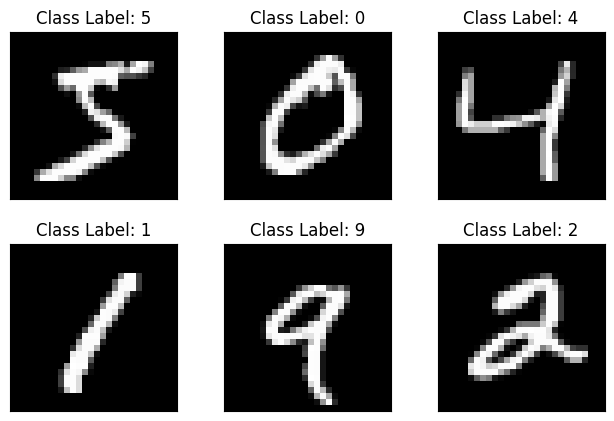

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0][0], cmap='gray', interpolation='none')
  plt.title("Class Label: {}".format(train_data[i][1]))
  plt.xticks([])
  plt.yticks([])


## Function to train the model

In [20]:
def train_model(model, train_loader, device, loss_fn, optimizer, input_dim=(-1,1,28,28)):
    model.train()
    # Initiate a loss monitor
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning and not supervised classification)
    for images, labels in train_loader: # the variable `labels` will be used for customised training
        # reshape input
        images = torch.reshape(images,input_dim)
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        # Backward pass (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log({"Training Loss": loss})
        wandb.watch(model)
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

## Function to test the model

In [21]:
# Testing Function
def test_model(model, test_loader, device, loss_fn, input_dim=(-1,1,28,28)):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        predicted = []
        actual = []
        for images, labels in test_loader:
            # reshape input
            images = torch.reshape(images,input_dim)
            images = images.to(device)
            labels = labels.to(device)
            ## predict the label
            pred = model(images)
            # Append the network output and the original image to the lists
            predicted.append(pred.cpu())
            actual.append(labels.cpu())
        # Create a single tensor with all the values in the lists
        predicted = torch.cat(predicted)
        actual = torch.cat(actual)
        # Evaluate global loss
        val_loss = loss_fn(predicted, actual)
    return val_loss.data

Before we start training let's delete the huge FC-Net we built and build a reasonable FC-Net (You learnt why such larger networks are not reasonable in the previous notebook)

In [22]:
del fc_net, fc_net_custom1, fc_net_custom2, fc_net_custom3
torch.cuda.empty_cache()
# Building a reasonable fully connected network
fc_net = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[128,64,32])

<b>Exercise 3.1.5:</b>
Code the `weight_init_xavier` function by referring to https://pytorch.org/docs/stable/nn.init.html. Replace the weight initializations to your own function.


In [23]:
### Set the random seed for reproducible results
torch.manual_seed(0)
# Choosing a device based on the env and torch setup
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

def weight_init_zero(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.constant_(m.weight, 0.0)
        m.bias.data.fill_(0.01)

def weight_init_xavier(m):
    '''
    TO-DO: please add code below to add xavier uniform initialization and remove the 'pass'
    '''
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

fc_net.to(device)
conv_net.to(device)

# Apply the weight initialization
fc_net.apply(weight_init_zero)
conv_net.apply(weight_init_zero)

# Apply the xavier weight initialization
#TO-DO: Add your function here
fc_net.apply(weight_init_xavier)
conv_net.apply(weight_init_xavier)


# Take the parameters for optimiser
params_to_optimize_fc = [
    {'params': fc_net.parameters()}
]

params_to_optimize_conv = [
    {'params': conv_net.parameters()}
]
### Define the loss function
loss_fn = torch.nn.NLLLoss()
### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

optim_fc = torch.optim.Adam(params_to_optimize_fc, lr=lr, weight_decay=1e-05)
optim_conv = torch.optim.Adam(params_to_optimize_conv, lr=lr, weight_decay=1e-05)
num_epochs = 30
wandb.config = {
  "learning_rate": lr,
  "epochs": num_epochs,
  "batch_size": batch_size
}

Selected device: cuda


# Training the Convolutional Neural Networks

In [24]:
print('Conv Net training started')
history_conv = {'train_loss':[],'val_loss':[]}
start_time = datetime.datetime.now()

for epoch in range(num_epochs):
    ### Training

    train_loss = train_model(
        model=conv_net,
        train_loader=train_loader,
        device=device,
        loss_fn=loss_fn,
        optimizer=optim_conv,
        input_dim=(-1,1,28,28))
    ### Validation  (use the testing function)
    val_loss = test_model(
        model=conv_net,
        test_loader=test_loader,
        device=device,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))
    # Print Losses
    print(f'Epoch {epoch+1}/{num_epochs} : train loss {train_loss:.3f} \t val loss {val_loss:.3f}')
    history_conv['train_loss'].append(train_loss)
    history_conv['val_loss'].append(val_loss)


print(f'Conv Net training done in {(datetime.datetime.now()-start_time).total_seconds():.3f} seconds!')

Conv Net training started


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1/30 : train loss 0.240 	 val loss 0.069
Epoch 2/30 : train loss 0.062 	 val loss 0.050
Epoch 3/30 : train loss 0.042 	 val loss 0.044
Epoch 4/30 : train loss 0.028 	 val loss 0.048
Epoch 5/30 : train loss 0.021 	 val loss 0.040
Epoch 6/30 : train loss 0.014 	 val loss 0.036
Epoch 7/30 : train loss 0.011 	 val loss 0.046
Epoch 8/30 : train loss 0.012 	 val loss 0.044
Epoch 9/30 : train loss 0.007 	 val loss 0.040
Epoch 10/30 : train loss 0.007 	 val loss 0.046
Epoch 11/30 : train loss 0.007 	 val loss 0.054
Epoch 12/30 : train loss 0.007 	 val loss 0.058
Epoch 13/30 : train loss 0.005 	 val loss 0.058
Epoch 14/30 : train loss 0.005 	 val loss 0.044
Epoch 15/30 : train loss 0.003 	 val loss 0.060
Epoch 16/30 : train loss 0.005 	 val loss 0.051
Epoch 17/30 : train loss 0.003 	 val loss 0.067
Epoch 18/30 : train loss 0.007 	 val loss 0.063
Epoch 19/30 : train loss 0.005 	 val loss 0.059
Epoch 20/30 : train loss 0.007 	 val loss 0.058
Epoch 21/30 : train loss 0.005 	 val loss 0.050
E

### Visualizing Training Progress of Conv Net (Also check out your wandb.ai homepage)

Text(0, 0.5, 'Negative Log Likelihood Loss')

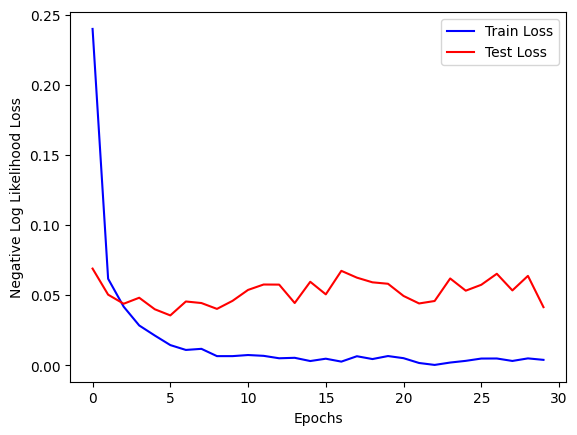

In [26]:
fig = plt.figure()
plt.plot(history_conv['train_loss'], color='blue')
plt.plot(history_conv['val_loss'], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')

### Visualizing Predictions of Conv Net

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


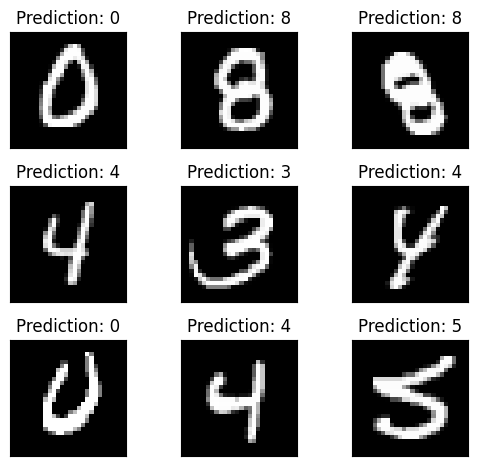

In [27]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = conv_net(example_data)
example_data = example_data.cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

# Training the Fully-Connected Neural Networks

<b>Exercise 3.1.6:</b> Train the fully connected neural network and analyse it

In [29]:
#TO-DO:Train the fc_net here
print('FC Net training started')

history_fc = {'train_loss':[],'val_loss':[]}
start_time = datetime.datetime.now()

for epoch in range(num_epochs):
    ### Training

    train_loss = train_model(
        model=fc_net,
        train_loader=train_loader,
        device=device,
        loss_fn=loss_fn,
        optimizer=optim_fc,
        input_dim=(-1,1,28,28))
    ### Validation  (use the testing function)
    val_loss = test_model(
        model=fc_net,
        test_loader=test_loader,
        device=device,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))
    # Print Losses
    print(f'Epoch {epoch+1}/{num_epochs} : train loss {train_loss:.3f} \t val loss {val_loss:.3f}')
    history_fc['train_loss'].append(train_loss)
    history_fc['val_loss'].append(val_loss)


print(f'FC Net training done in {(datetime.datetime.now()-start_time).total_seconds():.3f} seconds!')

FC Net training started


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1/30 : train loss 0.183 	 val loss 0.155
Epoch 2/30 : train loss 0.134 	 val loss 0.135
Epoch 3/30 : train loss 0.102 	 val loss 0.117
Epoch 4/30 : train loss 0.083 	 val loss 0.108
Epoch 5/30 : train loss 0.067 	 val loss 0.102
Epoch 6/30 : train loss 0.056 	 val loss 0.093
Epoch 7/30 : train loss 0.046 	 val loss 0.093
Epoch 8/30 : train loss 0.039 	 val loss 0.087
Epoch 9/30 : train loss 0.034 	 val loss 0.080
Epoch 10/30 : train loss 0.027 	 val loss 0.086
Epoch 11/30 : train loss 0.023 	 val loss 0.084
Epoch 12/30 : train loss 0.020 	 val loss 0.101
Epoch 13/30 : train loss 0.019 	 val loss 0.092
Epoch 14/30 : train loss 0.014 	 val loss 0.092
Epoch 15/30 : train loss 0.012 	 val loss 0.093
Epoch 16/30 : train loss 0.014 	 val loss 0.092
Epoch 17/30 : train loss 0.009 	 val loss 0.104
Epoch 18/30 : train loss 0.007 	 val loss 0.092
Epoch 19/30 : train loss 0.005 	 val loss 0.104
Epoch 20/30 : train loss 0.012 	 val loss 0.114
Epoch 21/30 : train loss 0.012 	 val loss 0.107
E

## Visualizing Training Progress of FC Net (Check out your wandb.ai project webpage)

Text(0, 0.5, 'Negative Log Likelihood Loss')

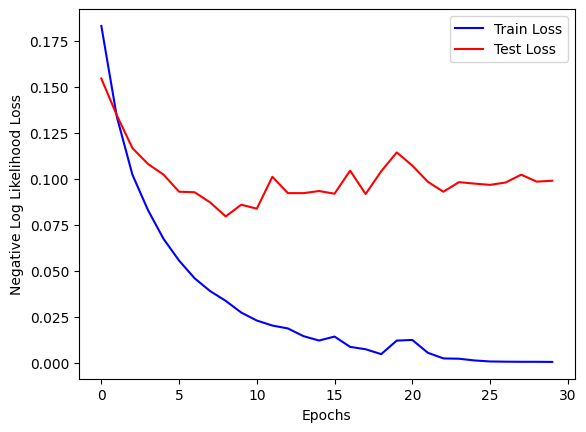

In [30]:
# TODO - Visualize the training progress of fc_net
fig = plt.figure()
plt.plot(history_fc['train_loss'], color='blue')
plt.plot(history_fc['val_loss'], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')

## Visualizing Predictions of FC Net

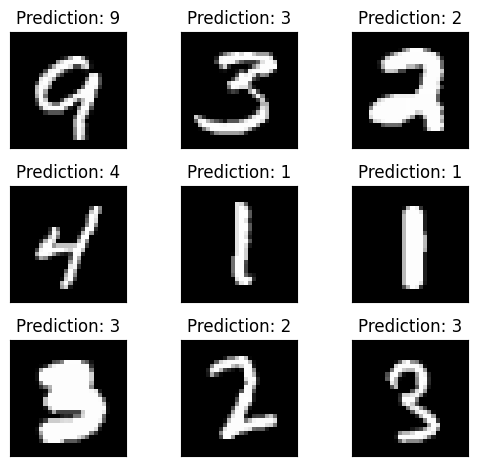

In [31]:
# TODO - Visualise the predictions of fc_net
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = fc_net(example_data)
example_data = example_data.cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

<b>Exercise 3.1.7</b>: What are the training times for each of the model? Did both the models take similar times? If yes, why? Shouldn't CNN train faster given it's number of weights to train?

**Answer:**

The training time for the models are as follows,

`Conv Net (CNN)` - 1001.499 seconds

`FC Net` - 693.015 seconds

In my environment both models did not take similar time for training. Since the training time depends on the network architectures and the computation resources used.

Although CNNs have lesser weights to train due to the weight sharing and invariance under translation properties, they can still have intensive computations like multi-dimentional matrix multiplications due to which the training time could increase.

## Let's see how the models perform under translation

In principle, one of the advantages of convolutions is that they are equivariant under translation which means that a function composed out of convolutions should invariant under translation.

<b>Exercise 3.1.8</b>: In practice, however, we might not see perfect invariance under translation.  What aspect of our network leads to imperfect invariance?

**Answer:** Since we are testing the CNN model on the MNIST dataset where the digits are centred. When we use translation methods like shift, the digits might shift too high and fall out of the visual field of a CNN fliter. Hence, Imperfect invariance under translation in a CNN can be caused by size of the filter and the CNN cannot capture the features required for classification.

We will next measure the sensitivity  of the convolutional network to translation in practice, and we will compare it to the fully-connected version.

In [32]:
## function to check accuracies for unit translation
def shiftVsAccuracy(model, test_loader, device, loss_fn, shifts = 12, input_dim=(-1,1,28,28)):
    # Set evaluation mode for encoder and decoder
    accuracies = []
    shifted = []
    for i in range(-shifts,shifts):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            predicted = []
            actual = []
            for images, labels in test_loader:
                # reshape input
                images = torch.roll(images,shifts=i, dims=2)
                if i == 0:
                    pass
                elif i > 0:
                    images[:,:,:i,:] = 0
                else:
                    images[:,:,i:,:] = 0
                images = torch.reshape(images,input_dim)
                images = images.to(device)
                labels = labels.to(device)
                ## predict the label
                pred = model(images)
                # Append the network output and the original image to the lists
                _ , pred = torch.max(pred.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                predicted.append(pred.cpu())
                actual.append(labels.cpu())
            shifted.append(images[0][0].cpu())
            acc = 100 * correct // total
            accuracies.append(acc)
    return accuracies,shifted

In [33]:
accuracies,shifted = shiftVsAccuracy(
        model=conv_net,
        test_loader=test_loader,
        device=device,
        shifts=12,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))

Text(0.5, 1.0, 'Accuracy Vs Translation')

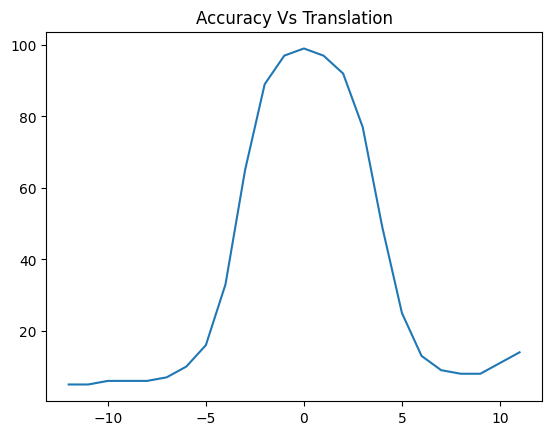

In [34]:
shifts = np.arange(-12,12)
plt.plot(shifts,accuracies)
plt.title('Accuracy Vs Translation')

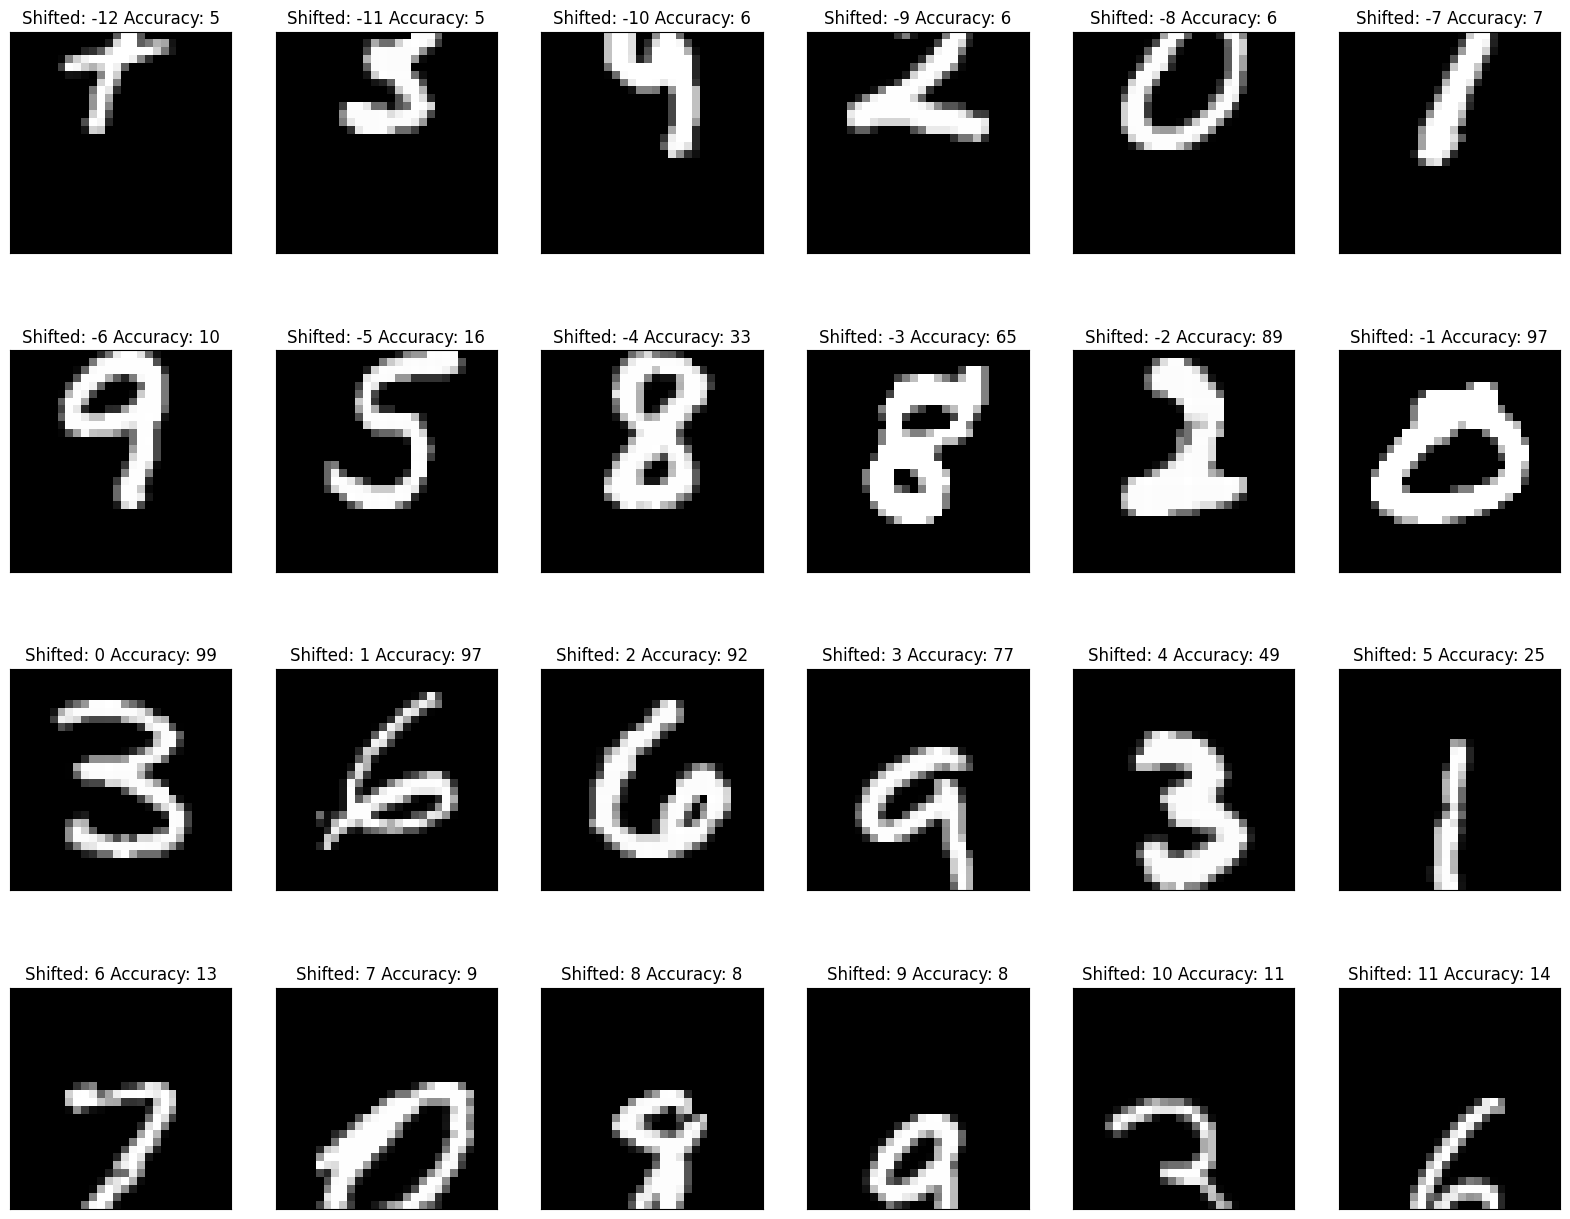

In [35]:
fig = plt.figure(figsize=(20,20))
plt_num = 0
for i in range(-12,12):
    plt.subplot(5,6,plt_num+1)
    plt.imshow(shifted[plt_num], cmap='gray',interpolation='none')
    plt.title(f"Shifted: {i} Accuracy: {accuracies[plt_num]}")
    plt.xticks([])
    plt.yticks([])
    plt_num+=1

<b>Exercise 3.1.8:</b>
Do the same for FC-Net and plot the accuracies. Is the rate of accuracy degradation same as Conv-Net? Can you justify why this happened? <br>
Clue: You might want to look at the way convolution layers process information

**Answer:**

* `Conv Net (CNN)`: The CNN has steady decrease in accuracy degradation till shift of `-4 to 4`. The model is able to perform well between shift of `-3 to 3` and has decent performance for shift of `-4 & 4`.

* `FC Net`: The FC net has good performance only with shifts of `-2 to 2` but the performance of the model suffers beyond a shift of `-3 & 3`.

This proves the ability of CNN to capture the translation invariance better than the FC net due to its capability to capture spatial hierarchies through the convolutional layers as opposed to the fully connected layers.

In [36]:
# To-DO Write your code below
accuracies_fc,shifted_fc = shiftVsAccuracy(
        model=fc_net,
        test_loader=test_loader,
        device=device,
        shifts=12,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Text(0.5, 1.0, 'Accuracy Vs Translation')

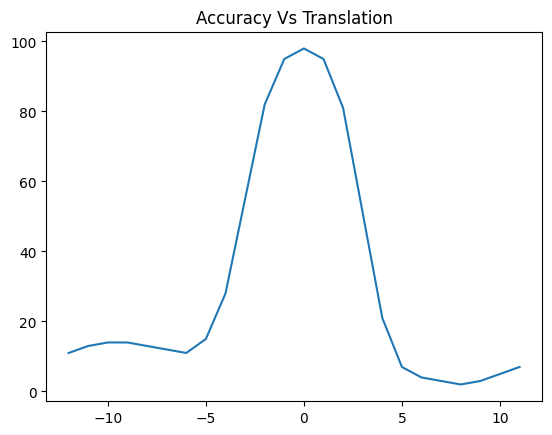

In [37]:
shifts = np.arange(-12,12)
plt.plot(shifts,accuracies_fc)
plt.title('Accuracy Vs Translation')

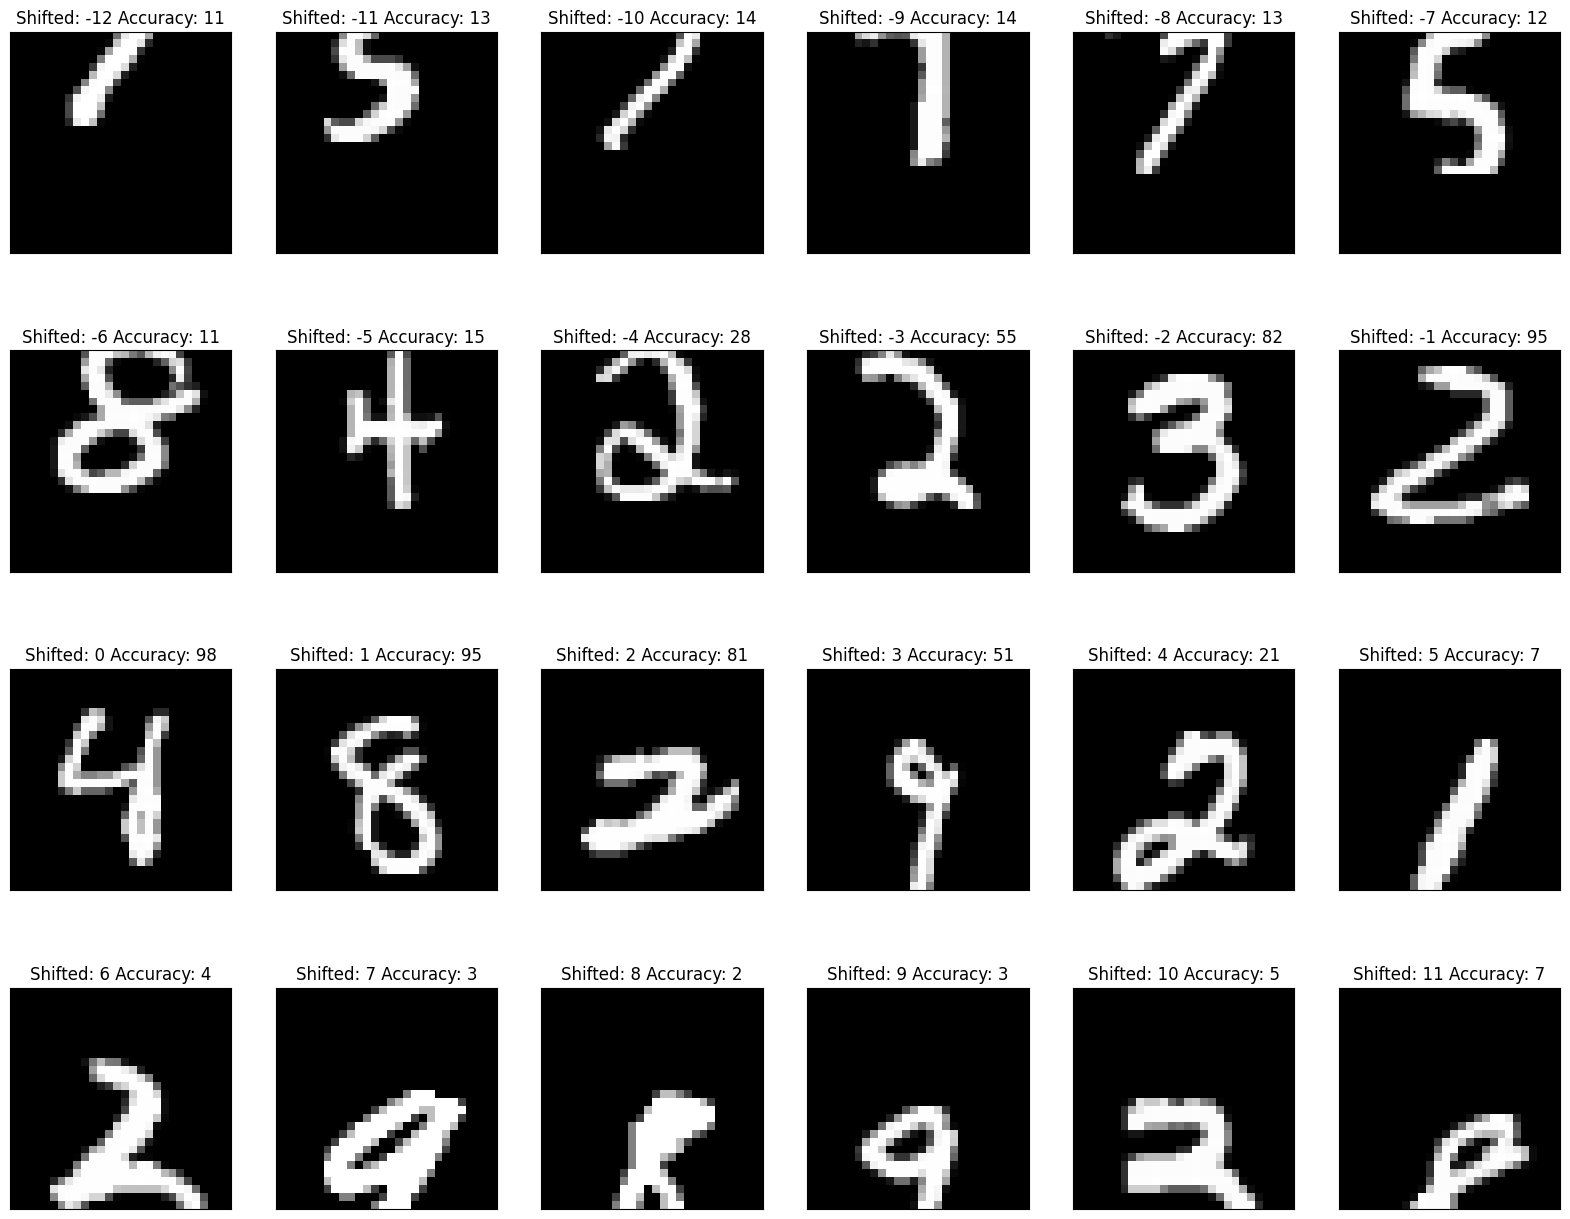

In [38]:
fig = plt.figure(figsize=(20,20))
plt_num = 0
for i in range(-12,12):
    plt.subplot(5,6,plt_num+1)
    plt.imshow(shifted_fc[plt_num], cmap='gray',interpolation='none')
    plt.title(f"Shifted: {i} Accuracy: {accuracies_fc[plt_num]}")
    plt.xticks([])
    plt.yticks([])
    plt_num+=1